In [3]:
import cv2
import numpy as np
from collections import deque

In [ ]:
from skimage.morphology import skeletonize
from scipy.interpolate import splprep, splev
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter


class ThreadBrightnessAnalyzer:
    """Класс для анализа яркости нити произвольной формы"""
    
    def __init__(self):
        # Настройка интерактивного отображения
        # plt.ion()
        self.fig, self.ax = plt.subplots(figsize=(12, 6))
        self.brightness_line, = self.ax.plot([], [], '-', linewidth=2, color='red')
        self.ax.set_xlabel('Расстояние вдоль нити (пиксели)')
        self.ax.set_ylabel('Яркость')
        self.ax.set_ylim(0, 255)
        
        # Создание окон визуализации
        cv2.namedWindow('wire analysis', cv2.WINDOW_NORMAL)
    
    def analyze(self, image, thread_mask, thickness=5):
        """
        Анализирует изображение и строит график яркости вдоль нити
        
        Args:
            image: Исходное изображение (BGR или grayscale)
            thread_mask: Бинарная маска нити
            thickness: Толщина для измерения яркости вдоль нити
            
        Returns:
            Координаты центральной линии нити и значения яркости
        """        
        # Получаем скелет маски нити
        skeleton = self._get_skeleton(thread_mask)
        
        # Получаем упорядоченные точки центральной линии нити
        centerline_points = self._get_centerline_points(skeleton)
        
        # Аппроксимируем центральную линию сплайном
        smoothed_points = self._smooth_centerline(centerline_points)
        
        # Если недостаточно точек, выходим
        if smoothed_points is None or len(smoothed_points[0]) < 2:
            print("Не удалось определить центральную линию нити")
            return None, None
        
        # Измеряем яркость вдоль аппроксимированной центральной линии
        distances, brightness_values = self._measure_brightness(
            image, smoothed_points, thickness)
        
        # Визуализируем результаты
        self._visualize_results(
            image, smoothed_points, distances, brightness_values)
        
        return smoothed_points, brightness_values
    def _get_skeleton(self, mask):
        """Получает скелет маски нити"""
        binary_mask = mask.astype(bool)
        skeleton = skeletonize(binary_mask)
        return skeleton.astype(np.uint8)
    
    def _get_centerline_points(self, skeleton):
        """Извлекает и упорядочивает точки центральной линии"""
        # Находим точки скелета
        y_coords, x_coords = np.where(skeleton > 0)
        
        if len(x_coords) == 0:
            return np.array([])
            
        # Объединяем координаты
        points = np.column_stack((x_coords, y_coords))
        
        # Находим две наиболее удаленные точки (концы нити)
        max_dist = 0
        endpoints = None
        
        # Если много точек, выбираем подмножество для ускорения
        if len(points) > 100:
            subset = points[np.random.choice(len(points), 100, replace=False)]
        else:
            subset = points
            
        for i in range(len(subset)):
            for j in range(i+1, len(subset)):
                dist = np.sum((subset[i] - subset[j])**2)
                if dist > max_dist:
                    max_dist = dist
                    endpoints = (subset[i], subset[j])
        
        if endpoints is None:
            return points
            
        # Ищем путь между концами нити
        ordered_points = self._find_path_between_endpoints(skeleton, endpoints)
        
        return np.array(ordered_points)
    
    def _find_path_between_endpoints(self, skeleton, endpoints):
        """Находит путь между двумя концами нити на скелете"""
        start, end = endpoints
        start = tuple(start)
        end = tuple(end)
        
        # Создаем копию скелета для поиска пути
        visited = np.zeros_like(skeleton, dtype=bool)
        queue = [(start, [start])]
        visited[start[1], start[0]] = True
        
        # Смещения для 8-связных соседей
        neighbors = [(-1,-1), (-1,0), (-1,1), (0,-1), (0,1), (1,-1), (1,0), (1,1)]
        
        while queue:
            (x, y), path = queue.pop(0)
            
            # Если дошли до конечной точки
            if (x, y) == end:
                return path
                
            # Проверяем соседей
            for dx, dy in neighbors:
                nx, ny = x + dx, y + dy
                
                # Проверяем границы изображения
                if nx < 0 or ny < 0 or nx >= skeleton.shape[1] or ny >= skeleton.shape[0]:
                    continue
                    
                # Если точка на скелете и еще не посещена
                if skeleton[ny, nx] > 0 and not visited[ny, nx]:
                    visited[ny, nx] = True
                    queue.append(((nx, ny), path + [(nx, ny)]))
        
        # Если путь не найден, возвращаем все точки скелета
        y_coords, x_coords = np.where(skeleton > 0)
        return np.column_stack((x_coords, y_coords))
    
    def _smooth_centerline(self, points, smoothing=50):
        """Аппроксимирует центральную линию нити сплайном"""
        if len(points) < 4:
            return None
            
        # Разделяем x и y координаты
        x = points[:, 0]
        y = points[:, 1]
        
        # Используем сплайн для сглаживания
        try:
            tck, u = splprep([x, y], s=smoothing)
            # Генерируем равномерно распределенные точки вдоль сплайна
            u_new = np.linspace(0, 1, 200)
            x_new, y_new = splev(u_new, tck)
            return np.array([x_new, y_new])
        except Exception as e:
            print(f"Ошибка при сглаживании: {e}")
            # Если не удалось аппроксимировать сплайном, используем полином
            try:
                # Сортируем точки по x-координате
                sorted_idx = np.argsort(x)
                x_sorted = x[sorted_idx]
                y_sorted = y[sorted_idx]
                
                # Аппроксимируем полиномом
                degree = min(5, len(x) - 1)
                coeffs = np.polyfit(x_sorted, y_sorted, degree)
                poly = np.poly1d(coeffs)
                
                # Генерируем равномерно распределенные точки
                x_new = np.linspace(min(x), max(x), 200)
                y_new = poly(x_new)
                return np.array([x_new, y_new])
            except Exception as e:
                print(f"Ошибка при аппроксимации полиномом: {e}")
                return None
    
    def _measure_brightness(self, image, smoothed_points, thickness):
        """Измеряет яркость изображения вдоль нити"""
        # Конвертируем в grayscale, если изображение цветное
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image
        
        x_points, y_points = smoothed_points
        brightness = np.zeros(len(x_points))
        
        # Вычисляем расстояние вдоль нити
        dx = np.diff(x_points)
        dy = np.diff(y_points)
        segment_lengths = np.sqrt(dx**2 + dy**2)
        distances = np.zeros_like(x_points)
        distances[1:] = np.cumsum(segment_lengths)
        
        # Для каждой точки центральной линии
        for i in range(len(x_points)):
            x, y = int(round(x_points[i])), int(round(y_points[i]))
            
            # Проверяем границы изображения
            if 0 <= x < gray.shape[1] and 0 <= y < gray.shape[0]:
                # Определяем область вокруг точки
                x_min = max(0, x - thickness // 2)
                x_max = min(gray.shape[1], x + thickness // 2 + 1)
                y_min = max(0, y - thickness // 2)
                y_max = min(gray.shape[0], y + thickness // 2 + 1)
                
                # Извлекаем область и измеряем среднюю яркость
                region = gray[y_min:y_max, x_min:x_max]
                if region.size > 0:
                    brightness[i] = np.mean(region)
        
        return distances, brightness
    
    def _visualize_results(self, image, smoothed_points, distances, brightness):
        """Визуализирует результаты анализа"""
        # Визуализируем центральную линию на изображении
        vis_image = image.copy()
        x_points, y_points = smoothed_points
        
        # Рисуем центральную линию
        points = np.column_stack((x_points.astype(np.int32), y_points.astype(np.int32)))
        for i in range(1, len(points)):
            cv2.line(vis_image, tuple(points[i-1]), tuple(points[i]), (0, 255, 0), 1)
        
        # Добавляем точки для наглядности
        for i in range(0, len(points), 10):
            cv2.circle(vis_image, tuple(points[i]), 3, (0, 0, 255), -1)
        
        # Отображаем визуализацию
        cv2.imshow('wire analysis', vis_image)
        
        # Обновляем график
        self.brightness_line.set_data(distances, savgol_filter(brightness, 15, 5))
        self.ax.set_xlim(0, max(distances))
        self.fig.canvas.draw_idle()
        self.fig.canvas.flush_events()
    
    def close(self):
        """Закрывает все окна и освобождает ресурсы"""
        cv2.destroyAllWindows()
        plt.ioff()
        plt.close(self.fig)

In [ ]:
# Глобальные переменные для отслеживания состояния
drawing = False  # Индикатор того, что мы сейчас рисуем
start_x, start_y = -1, -1  # Начальная точка
end_x, end_y = -1, -1  # Конечная точка
roi_selected = False  # Флаг выбранной области

def mouse_callback(event, x, y, flags, param):
    global drawing, start_x, start_y, end_x, end_y, roi_selected
    
    # Начало выделения области - нажатие левой кнопки мыши
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        start_x, start_y = x, y
        end_x, end_y = x, y
        roi_selected = False
    
    # Отслеживание перемещения мыши во время выделения
    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            end_x, end_y = x, y
    
    # Завершение выделения - отпускание кнопки мыши
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        end_x, end_y = x, y
        roi_selected = True

def main():
    global drawing, start_x, start_y, end_x, end_y, roi_selected
    
    # Инициализация захвата видео с камеры
    cap = cv2.VideoCapture(0)
    bri_deque = deque([0], maxlen=20)
    
    # Создание окна и регистрация обработчика событий мыши
    cv2.namedWindow('Video')
    cv2.setMouseCallback('Video', mouse_callback)

    cv2.namedWindow('Mask')

    analyzer = ThreadBrightnessAnalyzer()
    
    while True:
        ret, frame = cap.read()
        # frame = zoom_at(frame, 2)
        if not ret:
            break
        
        # Создаем копию кадра для отображения
        display_frame = frame.copy()
        
        # Если в процессе выделения, рисуем текущий прямоугольник
        if drawing:
            cv2.rectangle(display_frame, (start_x, start_y), (end_x, end_y), (0, 255, 0), 2)
        
        # Если область выделена, обрабатываем её
        if roi_selected:
            # Определяем координаты прямоугольника в правильном порядке
            x1, y1 = min(start_x, end_x), min(start_y, end_y)
            x2, y2 = max(start_x, end_x), max(start_y, end_y)
            
            # Проверяем, что область имеет размер
            if x1 != x2 and y1 != y2:
                # Выделяем выбранную область
                roi = frame[y1:y2, x1:x2]
                
                # Здесь ваша логика обработки ROI
                bri, mask = wire_brightness(roi)
                bri_deque.append(bri)
                cv2.imshow('Mask', cv2.bitwise_and(roi, roi, mask=mask))
                
                # Рисуем рамку выделенной области
                cv2.rectangle(display_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                key = cv2.waitKey(1) & 0xFF
                if key == ord('a'):
                    analyzer.analyze(roi, mask, thickness=2)
        
        # Показываем результат
        mean_bri = sum(bri_deque) / len(bri_deque)
        display_frame = cv2.putText(display_frame, f'bri: {mean_bri:.1f}', org=(10,30), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255,255,255))
        cv2.imshow('Video', display_frame)
        
        # Проверка нажатия клавиш
        key = cv2.waitKey(1) & 0xFF
        if key == 27:  # ESC - выход
            break
        elif key == ord('r'):  # R - сброс выделения
            roi_selected = False
    
    # Освобождаем ресурсы
    analyzer.close()
    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()

In [8]:
import random
plt.plot([random.random() for _ in range(10)])

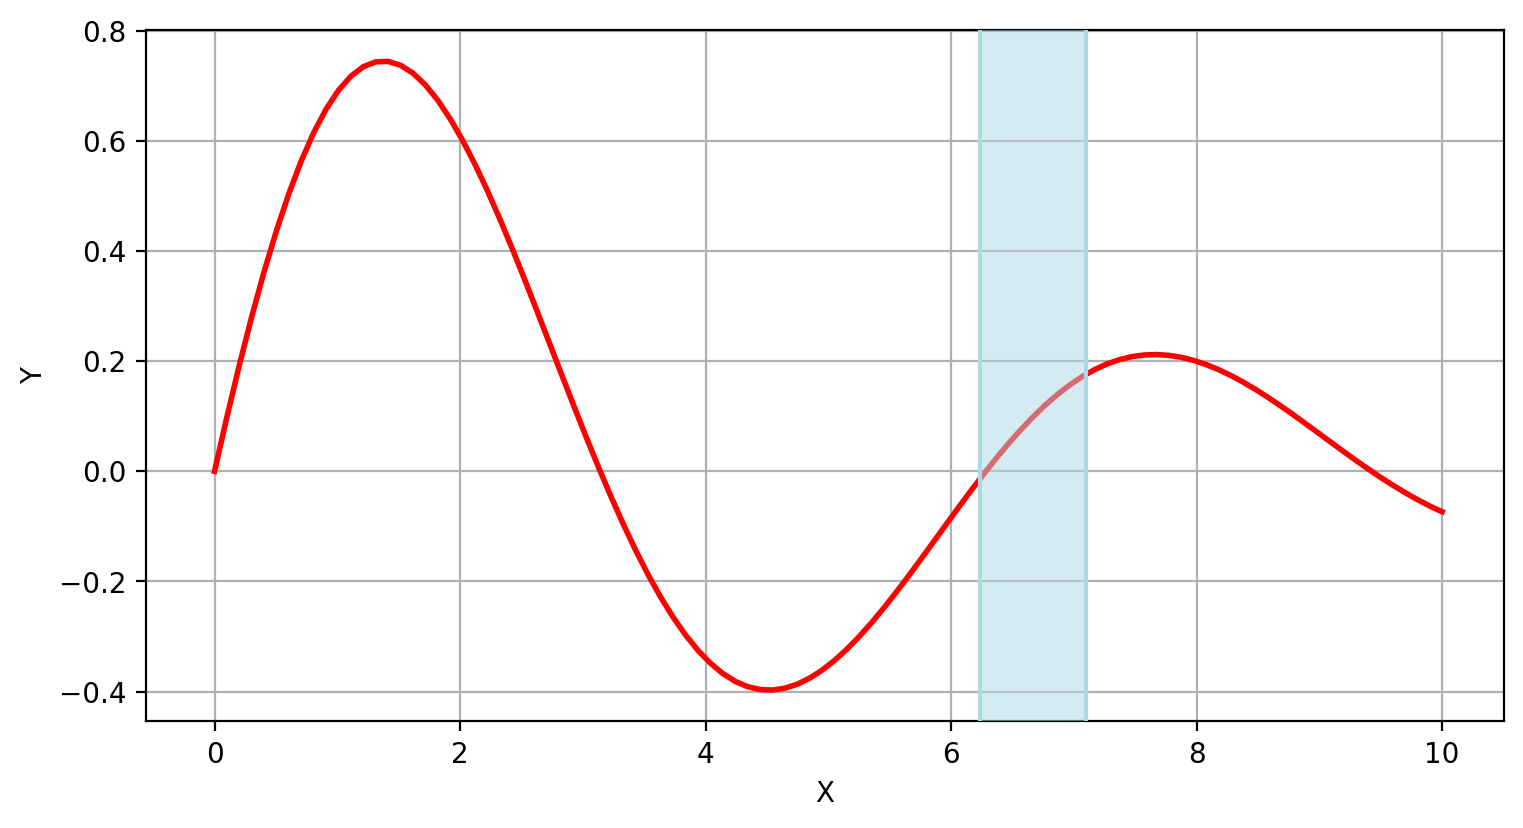

: 

In [ ]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_qtagg import FigureCanvasQTAgg, NavigationToolbar2QT
from PyQt6.QtWidgets import (QApplication, QMainWindow, QPushButton, QVBoxLayout, 
                            QHBoxLayout, QWidget, QFileDialog, QStatusBar)
from datetime import datetime
import csv
from matplotlib.widgets import SpanSelector

class MatplotlibCanvas(FigureCanvasQTAgg):
    def __init__(self, parent=None, width=5, height=4, dpi=100, xlabel="X", ylabel="Y"):
        # Создаем фигуру matplotlib
        self.fig, self.ax = plt.subplots(figsize=(width, height), dpi=dpi)
        super(MatplotlibCanvas, self).__init__(self.fig)
        
        # Инициализация графика с настраиваемыми метками осей
        self.line, = self.ax.plot([], [], 'r-', lw=2)
        self.ax.set_xlabel(xlabel)
        self.ax.set_ylabel(ylabel)
        self.ax.grid(True)

class GraphApp(QMainWindow):
    def __init__(self, xlabel="X", ylabel="Y"):
        super().__init__()
        
        # Настройка главного окна
        self.setWindowTitle("Интерактивный график (PyQt6)")
        self.setGeometry(100, 100, 900, 600)
        
        # Данные графика
        self.x_data = np.array([])
        self.y_data = np.array([])
        
        # Сохраняем метки осей
        self.xlabel = xlabel
        self.ylabel = ylabel
        
        # Инициализация UI
        self.init_ui()
        
        # Примерные данные для демонстрации
        x_demo = np.linspace(0, 10, 100)
        y_demo = np.sin(x_demo) * np.exp(-x_demo/5)
        
        # Обновляем график демо-данными
        self.update_plot(x_demo, y_demo)
        
        self.show()
        
    def init_ui(self):
        # Создание главного виджета и компоновки
        main_widget = QWidget()
        self.setCentralWidget(main_widget)
        main_layout = QVBoxLayout(main_widget)
        
        # Создание и добавление холста matplotlib
        self.canvas = MatplotlibCanvas(self, width=8, height=5, dpi=100, 
                                      xlabel=self.xlabel, ylabel=self.ylabel)
        main_layout.addWidget(self.canvas)
        
        # Добавление панели инструментов matplotlib
        toolbar = NavigationToolbar2QT(self.canvas, self)
        main_layout.addWidget(toolbar)
        
        # Создание компоновки для кнопок
        button_layout = QHBoxLayout()
        
        # Кнопки сохранения
        self.save_image_btn = QPushButton("Сохранить как изображение")
        self.save_image_btn.clicked.connect(self.save_as_image)
        button_layout.addWidget(self.save_image_btn)
        
        self.save_data_btn = QPushButton("Сохранить точки данных")
        self.save_data_btn.clicked.connect(self.save_data_points)
        button_layout.addWidget(self.save_data_btn)
        
        # Добавление компоновки кнопок в главную компоновку
        main_layout.addLayout(button_layout)
        
        # Добавление строки состояния
        self.status_bar = QStatusBar()
        self.setStatusBar(self.status_bar)
        self.status_bar.showMessage("Готов")
        
        # Добавление SpanSelector для выбора диапазона
        self.span_selector = SpanSelector(
            self.canvas.ax, 
            self.on_range_selected, 
            'horizontal', 
            useblit=True,
            props=dict(alpha=0.5, facecolor='lightblue'),
            interactive=True,
            drag_from_anywhere=True
        )
    
    def update_plot(self, x_data, y_data):
        """Обновление графика с переданными данными"""
        self.x_data = x_data
        self.y_data = y_data
        
        # Обновление графика
        self.canvas.line.set_data(self.x_data, self.y_data)
        self.canvas.ax.relim()      # Пересчет границ
        self.canvas.ax.autoscale_view(True, True, True)  # Автомасштабирование
        self.canvas.draw()
    
    def save_as_image(self):
        """Сохранение графика как изображения"""
        if len(self.x_data) == 0:
            self.status_bar.showMessage("Нет данных для сохранения", 5000)
            return
            
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        default_name = f"график_{timestamp}.png"
        
        filename, _ = QFileDialog.getSaveFileName(
            self, "Сохранить график как изображение", default_name, 
            "Изображения (*.png *.jpg *.jpeg *.pdf *.svg);;Все файлы (*)"
        )
        
        if filename:
            self.canvas.fig.savefig(filename, dpi=300, bbox_inches='tight')
            self.status_bar.showMessage(f"График сохранен как {os.path.basename(filename)}", 5000)
    
    def save_data_points(self):
        """Сохранение точек данных в CSV файл"""
        if len(self.x_data) == 0:
            self.status_bar.showMessage("Нет данных для сохранения", 5000)
            return
            
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        default_name = f"данные_{timestamp}.csv"
        
        filename, _ = QFileDialog.getSaveFileName(
            self, "Сохранить данные как CSV", default_name, 
            "CSV файлы (*.csv);;Все файлы (*)"
        )
        
        if filename:
            with open(filename, 'w', newline='') as csvfile:
                writer = csv.writer(csvfile)
                writer.writerow([self.xlabel, self.ylabel])  # Заголовок с настроенными названиями осей
                for x, y in zip(self.x_data, self.y_data):
                    writer.writerow([x, y])
            
            self.status_bar.showMessage(f"Данные сохранены как {os.path.basename(filename)}", 5000)
    
    def on_range_selected(self, min_val, max_val):
        """Обработка выбора диапазона и расчет среднего значения"""
        if len(self.x_data) == 0 or len(self.y_data) == 0:
            return
            
        # Находим индексы данных в выбранном диапазоне
        indices = [i for i, x in enumerate(self.x_data) if min_val <= x <= max_val]
        
        if not indices:
            self.status_bar.showMessage("В выбранном диапазоне нет данных", 5000)
            return
            
        # Рассчитываем среднее значение y в выбранном диапазоне
        selected_y_values = [self.y_data[i] for i in indices]
        mean_value = sum(selected_y_values) / len(selected_y_values)
        
        # Показываем информацию в статусной строке
        self.status_bar.showMessage(
            f"Диапазон X: [{min_val:.4f}, {max_val:.4f}], "
            f"Среднее значение {self.ylabel}: {mean_value:.4f}, "
            f"Количество точек: {len(indices)}"
        )

# Пример использования
if __name__ == "__main__":
    app = QApplication(sys.argv)
    plot = GraphApp()
    app.exec()

In [ ]:
from opencv_processing.main import main
main()

Exception in thread Thread-12 (run_camera):
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13/threading.py", line 1041, in _bootstrap_inner
    self.run()
    ~~~~~~~~^^
  File "/Users/gleblug/projects/vacuum-experiments/.venv/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
    ~~~~~~~~~~~~~~~~~~~~~^^^^^^
  File "/opt/homebrew/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13/threading.py", line 992, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/gleblug/projects/vacuum-experiments/src/opencv_processing/main.py", line 9, in run_camera
    cv2.namedWindow("Camera")
    ~~~~~~~~~~~~~~~^^^^^^^^^^
cv2.error: Unknown C++ exception from OpenCV code


: 